In [1]:
import os, sys

import numpy as np
import pandas as pd
import time, random, math
import copy, gc
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
import torch
from torch.optim import Adam
from torch.distributions import Categorical

In [2]:
from method_1 import SearchAvailablePosition
from method_2 import SearchAction
from method_3 import ChangeBoard

from Othello import Othello

In [3]:
#from RL.train_model import test, get_play_data, randomAgent, greedyAgent, getState
#from RL.train_model2 import test, get_play_data, randomAgent, greedyAgent, getState
from RL.train_model4 import test, get_play_data, randomAgent, greedyAgent, getState
#from RL.model import Model, basis_conv2d
from RL.optimize_model import optimize_a2cmodel as optimize_model
from RL.A2C_agent import agent as a2c_agent
from RL.DQN_agent import agent as dqn_agent
from RL.Replay_Memory import Replay_Memory
from RL.noise import AdaptiveParamNoiseSpec
from RL.utils import get_device

In [25]:
def train_main(N=100):
    win_1 = []
    win_2 = []
    noise = AdaptiveParamNoiseSpec(initial_stddev=0.5)
    agent = a2c_agent(
        input_dim=3, lam=0.6, gamma=.9, lr=1e-4, noise=noise)
    
    random_agent = randomAgent()
    greedy_agent = greedyAgent()
    loss = agent.init_param_optim(150)
    memory = Replay_Memory(400)

    for i in tqdm(range(N)):
        if i%4==0:
            agent_copy = copy.deepcopy(agent)
        for _ in range(4):
            tmp_w_1 = 0
            tmp_w_2 = 0
            agent_2 = np.random.choice([agent_copy, greedy_agent, random_agent])
            data_1, data_2 = get_play_data(agent , agent_2)
            memory.push(data_1)
            memory.push(data_2)
            tmp_w_1+=float(data_1['values'][0])
            tmp_w_2+=float(data_2['values'][0])

            win_1.append(tmp_w_1)    
            win_2.append(tmp_w_2)    
        agent.optimize_model(memory)
        
    win_1_df = pd.DataFrame()
    win_1_df['last_reward'] = win_1
    win_1_df['last_reward'] = win_1_df['last_reward'].rolling(10,min_periods=1).mean()
    win_1_df['result'] = (win_1_df['last_reward']>0).astype(int)
    win_1_df['result'] = win_1_df['result'].rolling(10,min_periods=1).mean()
    
    loss_df = pd.DataFrame()
    loss_df['loss_1'] = agent.loss_1_list
    loss_df['loss_2'] = agent.loss_2_list
    loss_df['loss_3'] = agent.loss_3_list
    loss_df['loss_1'] = loss_df['loss_1'].rolling(10,min_periods=1).mean()
    loss_df['loss_2'] = loss_df['loss_2'].rolling(10,min_periods=1).mean()
    loss_df['loss_3'] = loss_df['loss_3'].rolling(10,min_periods=1).mean()
    
    return agent, win_1_df, loss_df

In [31]:
agent, win_1_df, loss_df = train_main(N=600)

In [32]:
agent.noise.current_stddev

0.024281324579759515

In [33]:
#torch.save(agent.policy_model.state_dict(), 'a2c_param2.pt')

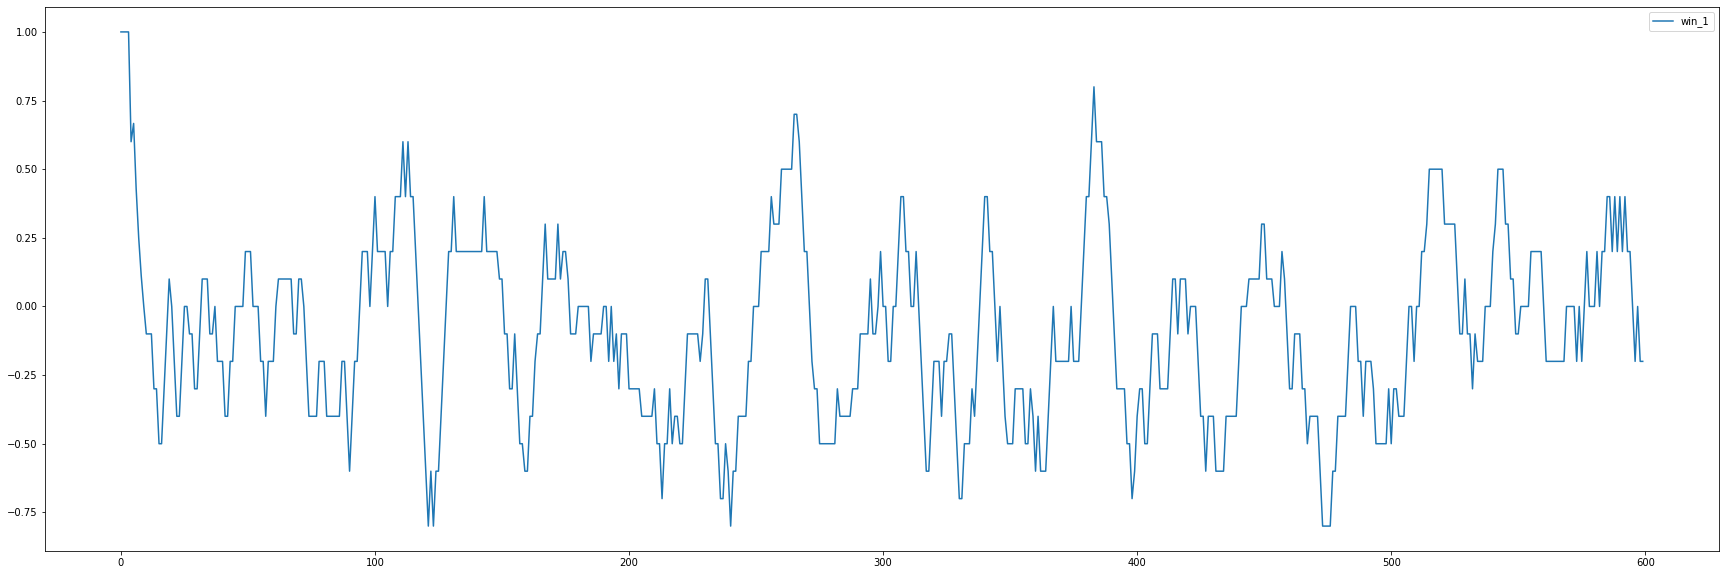

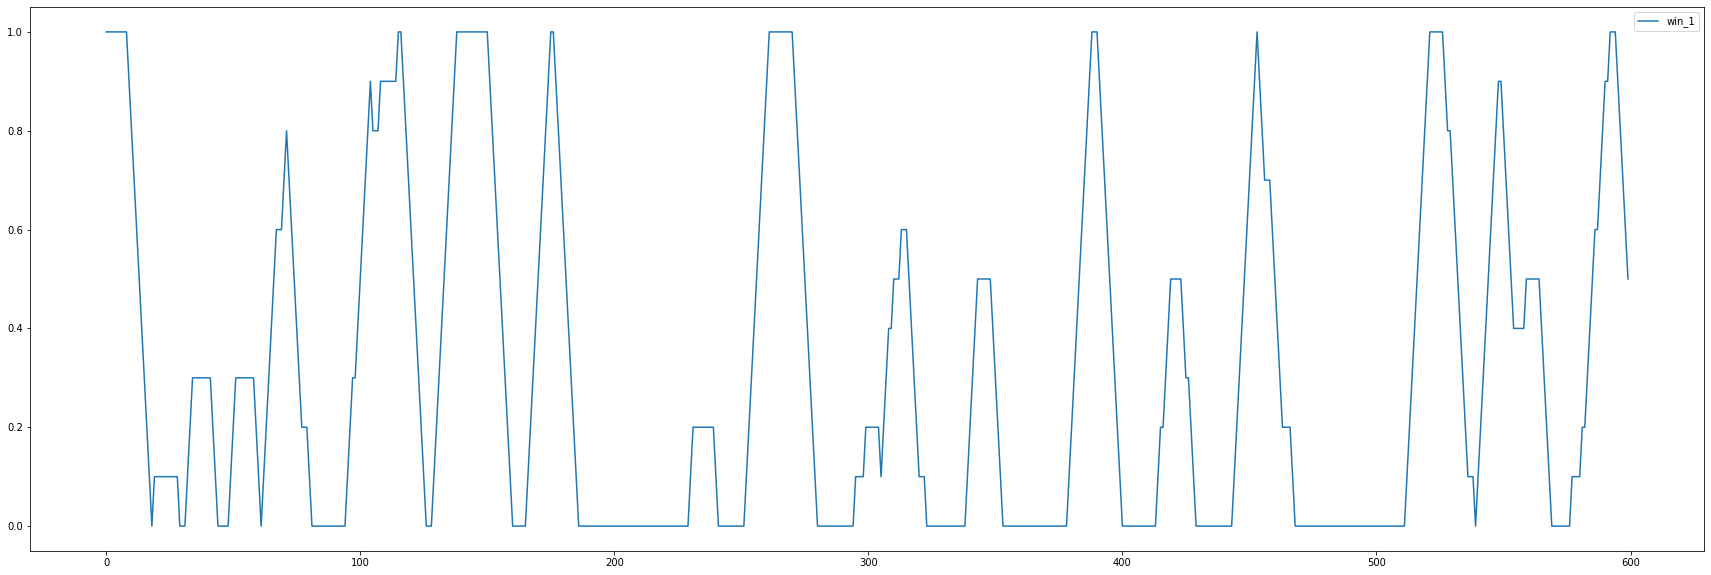

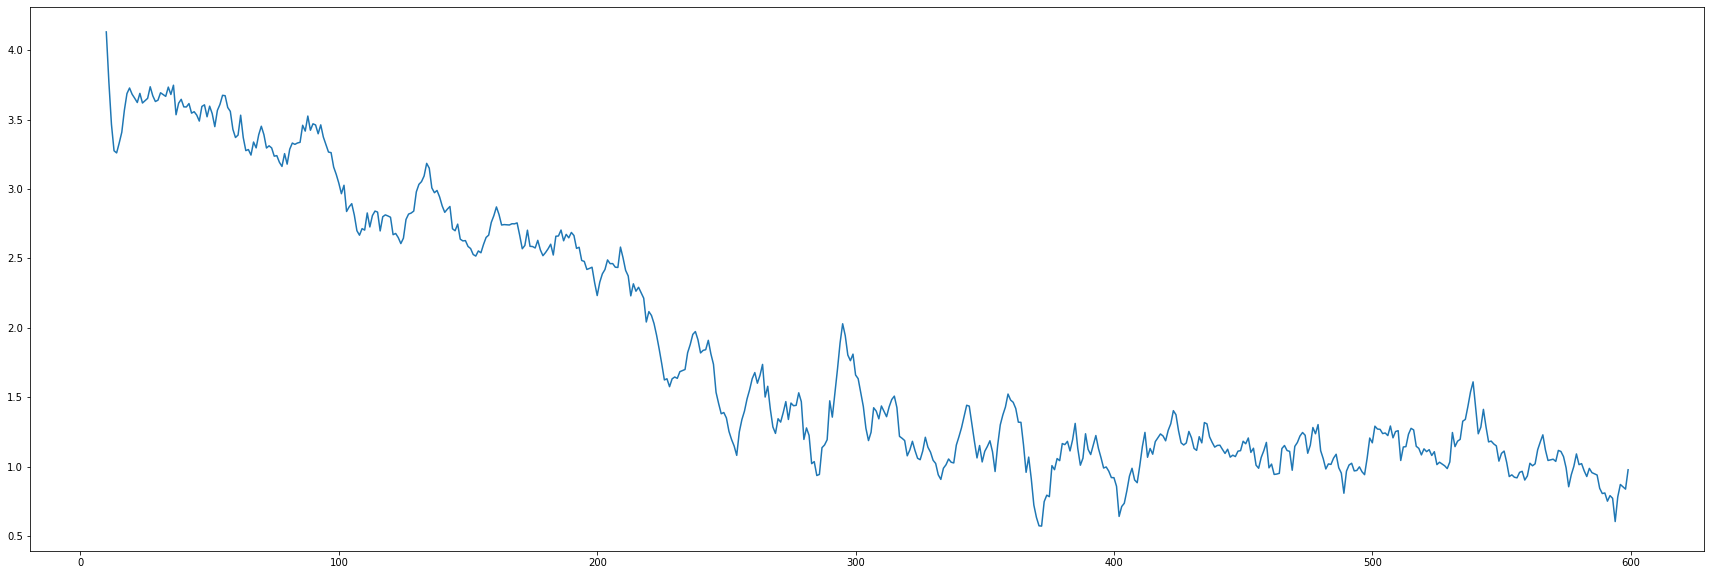

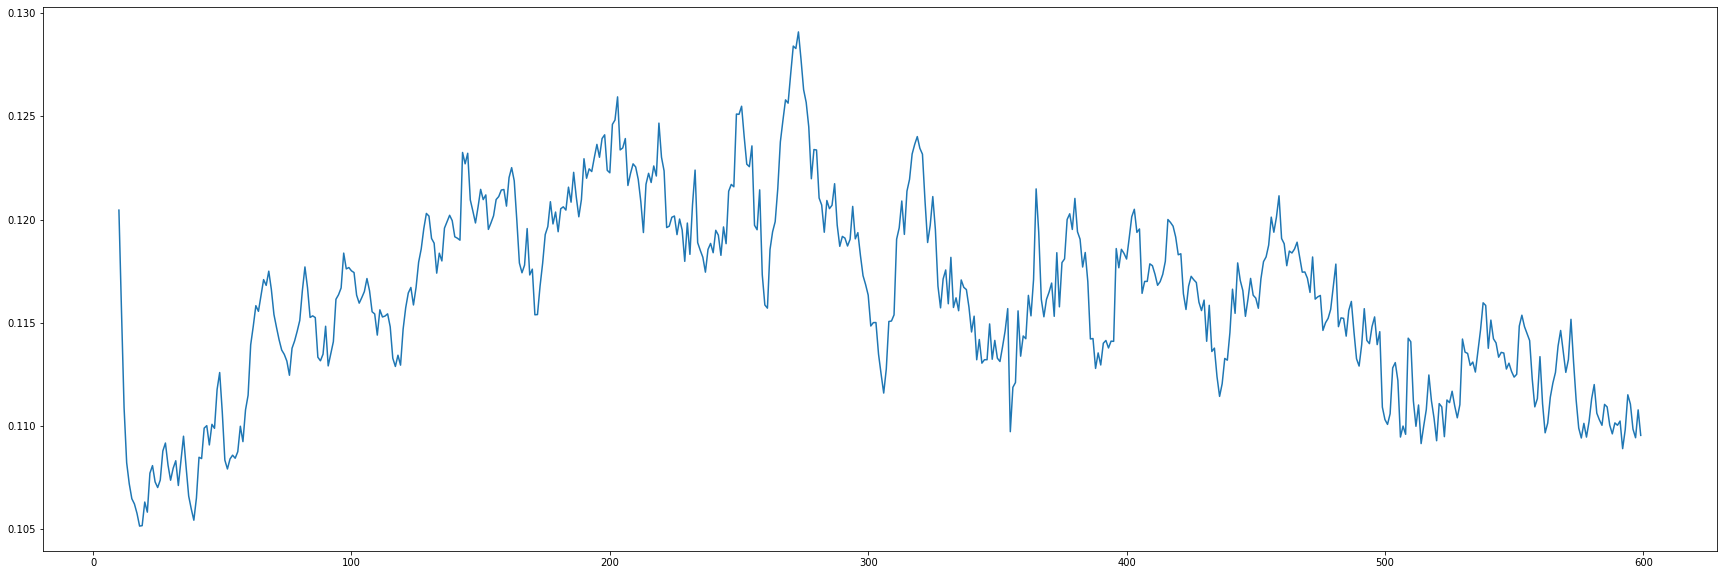

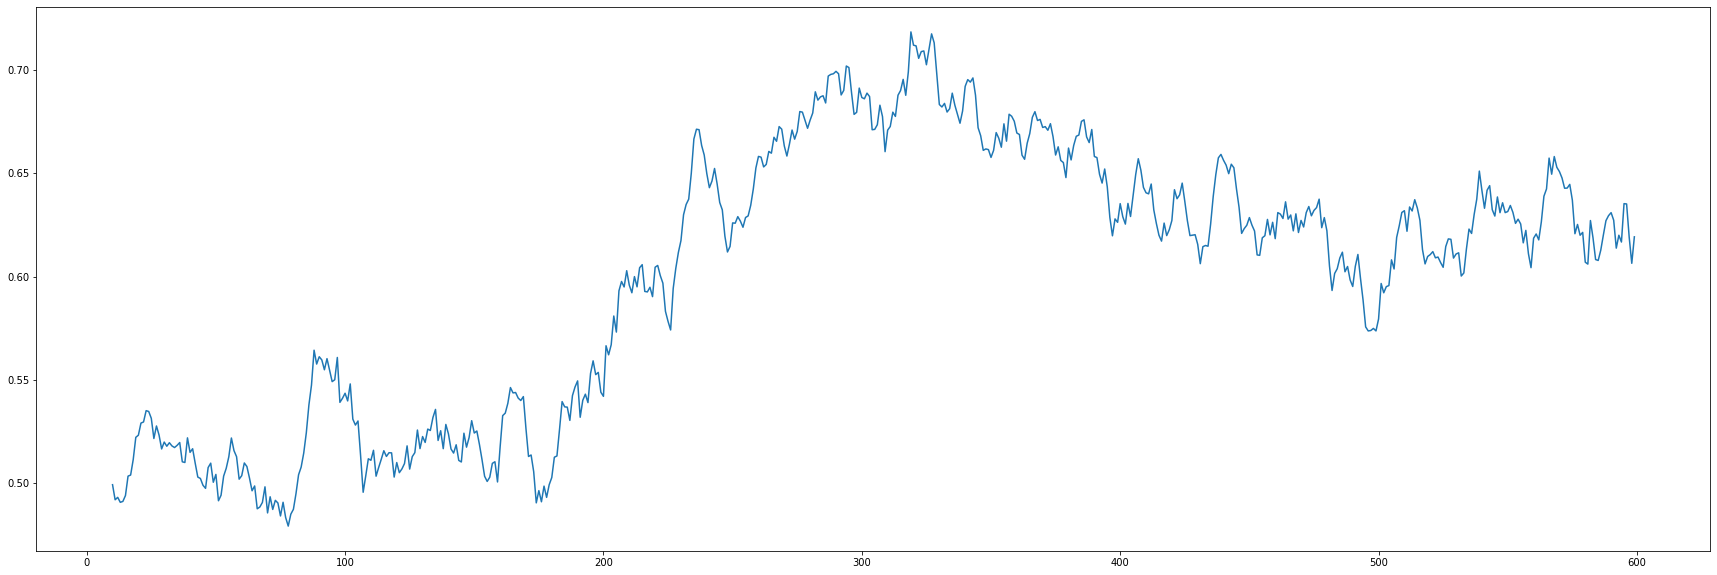

In [34]:
plt.figure(figsize=(30,10))
plt.plot(win_1_df['last_reward'], label='win_1')
plt.legend()
plt.show()

plt.figure(figsize=(30,10))
plt.plot(win_1_df['result'], label='win_1')
plt.legend()
plt.show()

for i in range(3):
    plt.figure(figsize=(30,10))
    plt.plot(loss_df[f'loss_{i+1}'][10:])
    plt.show()

In [35]:
#param = torch.load('dqn_param3.pt')
#dqn_1.policy_model.load_state_dict(param)

In [37]:
othello = Othello()
random_agent = randomAgent()
greedy_agent = greedyAgent()
w_1=0
w_2=0
draw=0

for _ in tqdm(range(800)):
    board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.make()
    while not done:
        if othello.color==1:
            setrow, setcol = agent.take_determ_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        else:
            #agent_tmp = random.choice([greedy_agent, random_agent])
            setrow, setcol = random_agent.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.step(setrow, setcol)
        if done:
            if len(board[board==1])>len(board[board==2]):
                w_1+=1
            elif len(board[board==1])<len(board[board==2]):
                w_2+=1
            else:
                draw+=1

In [38]:
print(w_1,w_2,draw)

343 419 38


In [39]:
othello = Othello()

w_1=0
w_2=0
draw=0

for _ in tqdm(range(800)):
    board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.make()
    while not done:
        if othello.color==1:
            #agent_tmp = random.choice([greedy_agent, random_agent])
            setrow, setcol = random_agent.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        else:
            setrow, setcol = agent.take_determ_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.step(setrow, setcol)
        if done:
            if len(board[board==1])>len(board[board==2]):
                w_1+=1
            elif len(board[board==1])<len(board[board==2]):
                w_2+=1
            else:
                draw+=1

In [40]:
print(w_1,w_2,draw)

403 359 38


In [41]:
othello = Othello()
random_agent = randomAgent()
greedy_agent = greedyAgent()
w_1=0
w_2=0
draw=0

for _ in tqdm(range(800)):
    board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.make()
    while not done:
        if othello.color==1:
            setrow, setcol = agent.take_determ_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        else:
            agent_tmp = random.choice([greedy_agent])
            setrow, setcol = agent_tmp.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.step(setrow, setcol)
        if done:
            if len(board[board==1])>len(board[board==2]):
                w_1+=1
            elif len(board[board==1])<len(board[board==2]):
                w_2+=1
            else:
                draw+=1

In [42]:
print(w_1,w_2,draw)

316 455 29


In [43]:
othello = Othello()

w_1=0
w_2=0
draw=0

for _ in tqdm(range(800)):
    board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.make()
    while not done:
        if othello.color==1:
            agent_tmp = random.choice([greedy_agent])
            setrow, setcol = agent_tmp.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        else:
            setrow, setcol = agent.take_determ_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.step(setrow, setcol)
        if done:
            if len(board[board==1])>len(board[board==2]):
                w_1+=1
            elif len(board[board==1])<len(board[board==2]):
                w_2+=1
            else:
                draw+=1

In [44]:
print(w_1,w_2,draw)

522 251 27
